## COSINE SIMILARITY e applicazione a KERMIT

In [1]:
pip install pyquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.9 MB/s 
     |████████████████████████████████| 4.7 MB 16.0 MB/s 
     |████████████████████████████████| 1.3 MB 43.9 MB/s 
     |████████████████████████████████| 101 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 43.7 MB/s 
     |████████████████████████████████| 6.6 MB 47.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=438ca1a2957d5282742ee0e2dbf1c768e9d609811b2759a347dd3f61b10f8d83
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
#Importiamo le dipendenze
import requests
import pandas as pd
import json
import torch
import urllib.request
from pyquery import PyQuery as pq
import networkx as nx

ConceptNet

In [33]:
#Importiamo le dipendenze
import requests
import pandas as pd
import json
import torch
import urllib.request
from pyquery import PyQuery as pq
import networkx as nx

#Richiamo il modello per calcolare la similarity
from sentence_transformers import SentenceTransformer
model_similarity = SentenceTransformer('paraphrase-distilroberta-base-v1')

def BestDescrizione(lista_descrizioni, text_caption, k):
  #Calcolo la similarità tra le descrizioni(surfaceText) e la caption/testo
  #k = iperparametro che mi dice quanti relazioni in conceptnet devo prendere per ogni parola
  sentence1 = model_similarity.encode(lista_descrizioni, convert_to_tensor=True)
  sentence2 = model_similarity.encode([text_caption], convert_to_tensor=True)
  #Ritorno una lista con l'indice dei 3 elementi più simili
  lista_piu_simili = []
  cosine_similarity = torch.nn.functional.cosine_similarity(sentence1, sentence2)
  array = cosine_similarity.cpu().detach().numpy().tolist()
  for i in range(0,k): #setta quante descrizioni vuoi
    if len(array)==0:
      return None
    massimo = max(array)
    indice = array.index(massimo)
    lista_piu_simili.append(indice)
    array.pop(indice)
  
  return lista_piu_simili

def Sinonimi(query):
    #Ritorno i sinonimi della parola "query"
    len_sinonimi=5
    try:
        d = pq(url=f'https://www.thesaurus.com/browse/{query}')
        lista_sinonimi = d('a.css-1kg1yv8.eh475bn0').text().split()
    except:
        lista_sinonimi = []
    return lista_sinonimi[:len_sinonimi] if len(lista_sinonimi)>0 else None


def SearchOnConceptNet(query, text_caption, k):
  #k = iperparametro che mi dice quanti relazioni in conceptnet devo prendere per ogni parola
  #Ricerca in ConceptNet
  if 'None' in query:
    return None
  
  request =  'http://api.conceptnet.io/c/en/' + query + '?filter=/c/en&limit=10000' 

  obj = requests.get(request).json()
  lista_descrizioni = []
  for i in obj['edges']:
    if (i['surfaceText'] != None) and ('is a translation of' not in i['surfaceText']):
        text = str(i['surfaceText']).replace('[','').replace(']','')
        text = text.lower() #deve essere in lower case
        lista_descrizioni.append(text)
        

  if len(lista_descrizioni) > 1:
    # Funzione che mi ritorna gli elementi migliori
    lista_indici_descrizioni_migliori = BestDescrizione(lista_descrizioni, text_caption, k)
    descrizioni_migliori = []
    if lista_indici_descrizioni_migliori == None:
      return None
    for i in lista_indici_descrizioni_migliori:
        descrizioni_migliori.append(lista_descrizioni[i])
    return descrizioni_migliori
  else:
    return None  

#rimuoviamo duplicati, stopwords, punteggiatura e lemmatizziamo
def remove_duplicates(lista):
  # Rimuove i duplicati dalla lista
  if not lista:
    return ['None']
  return list(dict.fromkeys(lista))

import re
def RemovePunct(text):
  #Rimuove le punct
  return re.sub(r'[^\w\s]', '', text) if text else 'None'

from gensim.parsing.preprocessing import remove_stopwords
#Funzione che rimuove le Stop Words
def RemoveStopWords(text):
  #Rimuove le stopwords
  return remove_stopwords(text) if text else 'None'  

# importing modules
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()


def Lemma(sentence):
  # Tokenize: Split the sentence into words
  word_list = word_tokenize(sentence)
  # Lemmatize list of words and join
  lemmatized_output = [lemmatizer.lemmatize(w) for w in word_list]
  return lemmatized_output


def ConoscenzaBase(text_meme, caption):
  #Rimuovo caratteri non necessari
  #Punct
  text_pulito = RemovePunct(text_meme)
  #StopWords
  text_pulito = RemoveStopWords(text_pulito)
  #Stemming
  text_pulito = Lemma(text_pulito)
  #Rimuovo duplicati
  lista_parole_meme = remove_duplicates(text_pulito)

  #caption
  #Punct
  text_pulito_cap = RemovePunct(caption)
  #StopWords
  text_pulito_cap = RemoveStopWords(text_pulito_cap)
  #Tolgo la parola photo
  text_pulito_cap = text_pulito_cap.replace('photo', '')
  #Stemming
  text_pulito_cap = Lemma(text_pulito_cap)
  #Rimuovo duplicati
  lista_parole_cap = remove_duplicates(text_pulito_cap)

  return lista_parole_meme, lista_parole_cap


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print(SearchOnConceptNet('person', 'two person was talking', 2))
print(SearchOnConceptNet('person', 'a black man hit a woman', 3))
print(SearchOnConceptNet('person', 'a man take a photo of the place', 1))
print(SearchOnConceptNet('person', 'a man was injured', 2))
print(SearchOnConceptNet('person', 'black lives matter', 4))

['a person wants communication', "a person doesn't want to miss the boat"]
['white person is a type of person', 'person is related to woman', 'a person can cross a street']
['a person can leave a place']
["a person doesn't want a broken leg", 'a person can be at the hospital']
['white person is a type of person', 'life is a type of person', 'a person wants to understand the events of history', 'a person wants cotton candy']


In [55]:
meme_text = 'anhdbud animal fiefbihgb ejeihr fruit gh'
text_captioning = 'an animal that eating'

#Level 0 Knowledge
list_words_meme, list_words_caption = ConoscenzaBase(meme_text, text_captioning)
print(list_words_meme)
print(list_words_caption)

['anhdbud', 'animal', 'fiefbihgb', 'ejeihr', 'fruit', 'gh']
['animal', 'eating']


In [16]:
def ConoscenzaLivelloUno(list_words_meme, text_caption, k):
  #k = iperparametro che mi dice quanti relazioni in conceptnet devo prendere per ogni parola
  #Ad ogni parola presente nella lista trovo la corrispondente descrizione.
  ricerche_lvl_1=[]
  #Questa è informazione di livello 1
  for word in list_words_meme:
    descrizioni = SearchOnConceptNet(word, text_caption, k)
    #gestiamo il caso in cui conceptnet non ritorni nulla
    if descrizioni == None:
      descrizioni = ['None', 'None', 'None']
    ricerche_lvl_1.append(descrizioni)
  #print(ricerche_lvl_1)
  #Contemporaneamente Rimuovo le StopWords
  temp = []
  for i in ricerche_lvl_1:
    temp2 = []
    for j in i:
      if j:
        elem = RemoveStopWords(j)
        temp2.append(elem)
      else:
        temp2.append('None')
    temp.append(temp2)
  ricerche_lvl_1 = temp
  #print(ricerche_lvl_1)
  #Rimuovo punct(Con ConceptNet non serve perchè le descrizioni non hanno punteggiatura)
  temp = []
  for i in ricerche_lvl_1:
    temp2 = []
    for j in i:
      if j:
        elem = RemovePunct(j)
        temp2.append(elem)
      else:
        temp2.append('None')
    temp.append(temp2)
  ricerche_lvl_1 = temp
  #print(ricerche_lvl_1)
  #Cerco i sinonimi
  sinonimi_lvl_0 = [Sinonimi(elem) for elem in list_words_meme]

  #Faccio lemming delle ricerche di lvl_1
  temp = []
  for i in ricerche_lvl_1:
    temp2 = []
    for j in i:
      if j:
        elem = Lemma(j)
        temp2.append(elem)
      else:
        temp2.append('None')
    temp.append(temp2)
  list_words_meme_lvl_1 = temp
  #print(list_words_meme_lvl_1)
  #Per ogni sinonimo trovato devo splittare e ricercare su wikidata
  #->matrix of words
  temp = []
  for i in list_words_meme_lvl_1:
    temp2 = []
    for j in i:
      for m in j:
        if m:
          elem = m.split()
          temp2.append(elem)
        else:
          temp2.append('None')
    temp.append(temp2)
  list_words_meme_lvl_1 = temp
  #print(list_words_meme_lvl_1)
  #ogni parola finisce in una lista a se, io devo mettere parole relative ad una stesso oggetto del meme tutte in una lista
  temp = []
  for i in list_words_meme_lvl_1:
    temp2 = []
    for j in i:
      temp2.append(j[0]) #devi prendere la stringa non una lista con la stringa
    temp.append(temp2)
  list_words_meme_lvl_1 = temp
  #print(list_words_meme_lvl_1)

  #devo rimuovere i duplicati
  temp = []
  
  for i in list_words_meme_lvl_1:
    temp2 = []
    for j in i:
      if j not in temp2:
        temp2.append(j)
    temp.append(temp2)
  list_words_meme_lvl_1 = temp

  #l'output sarà una lista di liste, dove la lista i-esima ha le parole relative all'oggetto i-esimo estratto dal testo/immagine del meme
  return list_words_meme_lvl_1, sinonimi_lvl_0


In [56]:
list_words_meme_lvl_1, sinonimi_lvl_0 = ConoscenzaLivelloUno(list_words_meme, text_captioning, 3)
print(list_words_meme_lvl_1)
print(sinonimi_lvl_0)

[[], ['animal', 'eating', 'want', 'eat', 'tiger'], [], [], ['fruit', 'eating', 'pineapple', 'type', 'pome'], []]
[None, ['bodily', 'natural', 'beast', 'creature', 'pet'], None, None, ['berry', 'crop', 'grain', 'nut', 'produce'], None]


In [24]:
def ConoscenzaLivelloDue(list_words_meme_lvl_1, text_caption, k):

  #Devo ora sviluppare la conoscenza di livello 2

  list_words_meme_lvl_2 = []
  #Ricerca informazioni di secondo livello
  for i in range(len(list_words_meme_lvl_1)):
    list_words_meme_prov = [] #deve essere una lista di liste di liste
    if not list_words_meme_lvl_1[i]:
      #Considero il caso in cui conceptnet non ritorni nulla per la parola i-esima
      list_words_meme_prov.append('None')
      lunghezza = 0
    else:
      lunghezza=len(list_words_meme_lvl_1[i]) #lunghezza della lista di parole della parola i-esima
    for j in range(lunghezza):
      #per ogni parola nella lista della parola i-esima faccio ricerca in conceptnet, e mi ritorna una lista di k elementi
      lista_descrizioni_lvl_2 = []
      lista_descrizioni_lvl_2 = SearchOnConceptNet(list_words_meme_lvl_1[i][j], text_caption, k)
      #se ConceptNet non mi ritorna nulla, la lista sarà vuota
      if lista_descrizioni_lvl_2 == None:
        lista_descrizioni_lvl_2 = ['None', 'None', 'None']
      #print(lista_descrizioni_lvl_2)
    #Rimuovo le stopwords
      temp = []
      for m in lista_descrizioni_lvl_2:
        temp2 = []
        if m:
          elem = RemoveStopWords(m)
          temp2.append(elem)
        else:
          temp2.append('None')
        temp.append(temp2)
      lista_descrizioni_lvl_2 = temp
      #print(lista_descrizioni_lvl_2)
    #adesso avrò una lista di liste di descrizioni di livello 2
      list_words_meme_prov.append(lista_descrizioni_lvl_2)
    list_words_meme_lvl_2.append(list_words_meme_prov)
  #print(list_words_meme_lvl_2)
  
  
  #dopo che ho trovato tutte le liste devo splittare etc...
  temp = []
  for i in list_words_meme_lvl_2:
    temp2 = []
    for j in i:
      temp3 = []
      for n in j:
        for m in n:
          if m:
            elem = m.split()
            temp3.append(elem)
          else:
            temp3.append('None')
      temp2.append(temp3)    
    temp.append(temp2)
  list_words_meme_lvl_2 = temp
  #print(list_words_meme_lvl_2)
  #ogni parola finisce in una lista a se, io devo mettere parole relative ad una stesso oggetto del meme tutte in una lista
  temp = []
  for i in list_words_meme_lvl_2:
    temp2 = []
    for n in i:
      temp3 = []
      for j in n:
        temp3.append(j[0]) #devi prendere la stringa non una lista con la stringa
      temp2.append(temp3)
    temp.append(temp2)
  list_words_meme_lvl_2 = temp
  #print(list_words_meme_lvl_2)

  #devo rimuovere i duplicati
  temp = []
  
  for i in list_words_meme_lvl_2:
    temp2 = []
    for n in i:
      temp3 = []
      for j in n:
        if j not in temp3:
          temp3.append(j)
      temp2.append(temp3)
    temp.append(temp2)  
  list_words_meme_lvl_2 = temp

  return list_words_meme_lvl_2

In [57]:
list_words_meme_lvl_2 = ConoscenzaLivelloDue(list_words_meme_lvl_1, text_captioning, 3)
print(list_words_meme_lvl_2)

[[['N', 'o', 'n', 'e']], [['animal', 'tiger'], ['animal', 'engorgement', 'effect'], ['need', 'want'], ['animal', 'thing'], ['tiger']], [['N', 'o', 'n', 'e']], [['N', 'o', 'n', 'e']], [['fruit', 'pineapple', 'pome'], ['animal', 'engorgement', 'effect'], ['*something', 'ananas', 'pineapple'], ['zucchini', 'thing', 'type'], ['pome', 'quince', 'pear']], [['N', 'o', 'n', 'e']]]


In [46]:
def GenerazioneGrafo(list_words_meme, list_words_meme_lvl_1, list_words_meme_lvl_2, list_words_caption, sinonimi_lvl_0):
  # Genero ora la matrice di adiacenza che mi serve per generare il grafo

  # list_words_meme ---> contiene i termini di base del meme
  # sinonimi_lvl_0  ---> contiene i sinonimi di base al meme
  # list_words_meme_lvl_1
  # list_words_meme_lvl_2

  rows = []

  # Partiamo col collegare totalmente le parole estratte dal meme
  lista = list_words_meme
  for i in list_words_meme:
    for j in lista:
      if i != j and [i, j, 1] not in rows and [i, j, 1] not in rows:
        rows.append([i, j, 1])
        rows.append([j, i, 1])


  # Devo ora collegare ogni parola con la sua descrizione di livello 1
  for i in range(len(list_words_meme)):
    # Collego prima il grafo principale con quello di livello 1
    # Inserisco una profondità pari a 2, cioè sono al livello 1
    for j in range(len(list_words_meme_lvl_1[i])):
      #questo if serve per evitare situazioni del tipo (animal, animal, 2)
      if list_words_meme_lvl_1[i][j] != list_words_meme[i]:
        rows.append([list_words_meme_lvl_1[i][j], list_words_meme[i], 2])

  for i in range (len(list_words_meme_lvl_1)):
    for j in range(len(list_words_meme_lvl_1[i])):
      for m in range(len(list_words_meme_lvl_2[i][j])):
        #questo if serve per evitare situazioni del tipo (animal, animal, 3)
        if list_words_meme_lvl_1[i][j] != list_words_meme_lvl_2[i][j][m]:
          rows.append([list_words_meme_lvl_2[i][j][m], list_words_meme_lvl_1[i][j], 3])

  # Collego i sinonimi
  for i in range(len(sinonimi_lvl_0)):
    if sinonimi_lvl_0[i]:
      for j in range(len(sinonimi_lvl_0[i])):
        rows.append([list_words_meme[i], sinonimi_lvl_0[i][j], 1])
    else:
      continue


  #SICCOME USIAMO LA CAPTION PER FARE L'ESTRAZIONE DA CONCEPTNET
  #NON AVREBBE SENSO METTERE NEL GRAFO I NODI ESTRATTI DALLA CAPTION
  # Devo collegare le informazioni dell'immagine con i nodi principale
  for i in range(len(list_words_caption) - 1):
    # unisco prima l'ultimo col primo
    if i == 0:
      rows.append([list_words_meme[-1], list_words_caption[0], 1])
    else:
      rows.append([list_words_caption[i], list_words_caption[i + 1], 1])

  # Ho generato la matrice di adiacenza, ora deve diventare un grafo
  matrice_adiacenza_grafo_pd = pd.DataFrame(rows, columns=['source', 'target', 'depth'])
  graph = nx.from_pandas_edgelist(matrice_adiacenza_grafo_pd, source='source', target='target', edge_attr=True,
                                  create_using=nx.DiGraph())

  return matrice_adiacenza_grafo_pd, graph


In [58]:
matrice_adiacenza_grafo_pd, graph = GenerazioneGrafo(list_words_meme, list_words_meme_lvl_1, list_words_meme_lvl_2, list_words_caption, sinonimi_lvl_0)

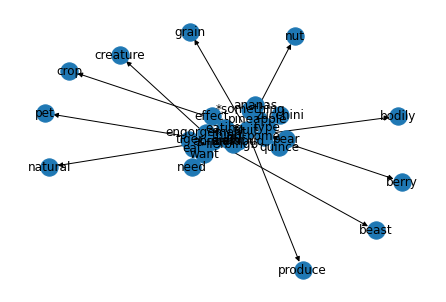

In [59]:
import networkx as nx

#Graph Visualize
nx.draw(graph, with_labels=True)

In [60]:
matrice_adiacenza_grafo_pd

,source,target,depth
0,anhdbud,animal,1
1,animal,anhdbud,1
2,anhdbud,fiefbihgb,1
3,fiefbihgb,anhdbud,1
4,anhdbud,ejeihr,1
...,...,...,...
62,fruit,crop,1
63,fruit,grain,1
64,fruit,nut,1
65,fruit,produce,1
